In [2]:
%cd /home/druhe/rail1/src/cnf/
%matplotlib widget
import os
os.environ['DATAROOT'] = '/home/druhe/datasets/'

/home/druhe/rail1/src/cnf/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/druhe/rail1/src/cnf


In [38]:
A, B, C = np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])

In [39]:
p = 1
q = 0

P, Q = np.array([p, p, p]), np.array([q, q, q])

In [75]:
torch_A = torch.from_numpy(A).double()
torch_B = torch.from_numpy(B).double()
torch_C = torch.from_numpy(C).double()
torch_vertices = torch.stack([torch_A, torch_B, torch_C])

torch_P = torch.from_numpy(P)[None].double()
torch_Q = torch.from_numpy(Q)

torch_P = torch_P.repeat(2, 1)
torch_Q = torch_Q.repeat(2, 1)

ray_intersects_triangle(torch_P, torch_Q - torch_P, torch_vertices)

tensor([True, True])

In [41]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a default mesh, for example, a sphere
mesh = o3d.geometry.TriangleMesh.create_sphere()

# Convert mesh to numpy arrays
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)


In [42]:
vertices /= 2

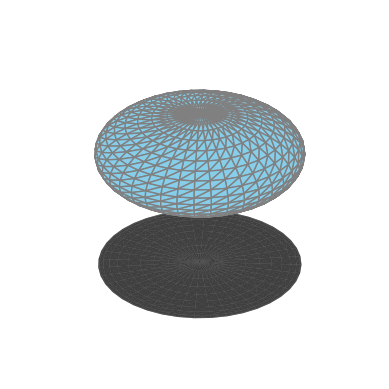

In [43]:

# Extract x, y, and z coordinates
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

# Plotting the original mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mesh_plot = ax.plot_trisurf(x, y, triangles, Z=z, shade=False, color='skyblue', edgecolor='grey')

# Creating and plotting the shadow
shadow_z = np.full_like(z, -1.5)  # Set all z-coordinates of the shadow to -1.5
shadow_plot = ax.plot_trisurf(x, y, triangles, Z=shadow_z, shade=False, color='black', edgecolor='none', alpha=0.5)

# Removing the axes
ax.axis('off')

plt.show()


In [45]:
# vertices that make up the faces
faces = mesh.triangles


In [46]:
triangle_vertices = torch.from_numpy(vertices[triangles]).float()

In [76]:
import numpy as np
import torch
EPSILON = torch.finfo().eps

def ray_intersects_triangle(
    torch_origin,
    torch_direction,
    torch_vertices):
    # v0, v1, v2 = triangle_vertices
    torch_v0, torch_v1, torch_v2 = torch_vertices[:, 0], torch_vertices[:, 1], torch_vertices[:, 2]

    # e1 = v1 - v0
    # e2 = v2 - v0

    torch_e1 = torch_v1 - torch_v0
    torch_e2 = torch_v2 - torch_v0

    # h = np.cross(ray_direction, e2)
    ray_cross_e2 = torch.cross(torch_direction, torch_e2)
    
    # det = np.dot(e1, h)
    det_torch = torch.einsum('i, bi->b', torch_e1, ray_cross_e2)

    torch_results = torch.zeros((len(det_torch),), dtype=torch.bool)
    
    # if -1e-7 < det < 1e-7:
    #     return False  # This means the ray is parallel to the triangle.
    
    # f = 1.0 / det  # inv_det
    f_torch = 1. / det_torch
    # s = ray_origin - v0
    s_torch = torch_origin - torch_v0

    u_torch = f_torch * torch.einsum('bi, bi->b', s_torch, ray_cross_e2)
    # u = f * np.dot(s, h)
    
    # if u < 0.0 or u > 1.0:
    #     return False
    
    # q = np.cross(s, e1)
    s_cross_e1 = torch.cross(s_torch, torch_e1, dim=1)

    # v = f * np.dot(ray_direction, q)
    v_torch = f_torch * torch.einsum('bi, bi->b', torch_direction, s_cross_e1)
    
    # if v < 0.0 or u + v > 1.0:
    #     return False

    # t = f * np.dot(edge2, q)
    t_torch = f_torch * torch.einsum('i, bi->b', torch_e2, s_cross_e1)

    torch_results[t_torch > 1e-7] = True
    torch_results[(v_torch < 0) | (u_torch + v_torch > 1.)] = False
    torch_results[(u_torch < 0) | (u_torch > 1)] = False
    torch_results[torch.abs(det_torch) < 1e-7] = False

    return torch_results


    # if t > 1e-7:  # ray intersection
    #     return True, torch_results
    # else:  # This means that there is a line intersection but not a ray intersection.
    #     return False, torch_results




In [83]:
def is_inside_mesh(points, triangle_vertices):
    direction = torch.tensor([1., 0., 0.])

    counts = torch.zeros(len(points))

    for triangle in triangle_vertices:
        counts += ray_intersects_triangle(points, direction - points, triangle)

    return points[counts % 2 == 1]


In [85]:
inside_sphere = []

while len(inside_sphere) < 100:
    uniform = torch.rand(100, 3) * 2 - 1
    inside_sphere.append(is_inside_mesh(uniform, triangle_vertices))
    print(len(inside_sphere))